# Example of Randomization Via Stub-Matching



In [45]:
import numpy as np
import json

from math import pi

from ahyper import utils, annotated_hypergraph
from matplotlib import pyplot as plt

In [2]:
with open('data/enron_hypergraph_annotated.json') as file:
    data = json.load(file)

roles = ['cc', 'from', 'to']

A = annotated_hypergraph.AnnotatedHypergraph(data, roles)

In [11]:
a = A.stub_matching()

In [12]:
a.count_degeneracies()

518

In [13]:
test1 = a.edge_dimensions(by_role = True) == A.edge_dimensions(by_role = True)
test2 = a.node_degrees(by_role = True)    == A.node_degrees(by_role = True)
test1, test2

(True, True)

# Stub Matching Experiment

While we could try to derive analytic estimates or Poisson limit laws for the degeneracy created by stub-matching, an alternative is just to simulate: 

In [23]:
n_reps = 500

def experiment():
    a = A.stub_matching()
    return(a.count_degeneracies())

v = np.array([experiment() for i in range(n_reps)])

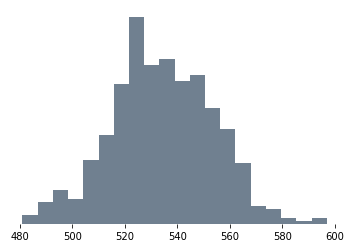

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(v, bins = 20, color = 'slategrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig('fig/stub_matching_degeneracy.png', dpi = 300)

In [39]:
mu = v.mean()
sigma = np.sqrt(np.var(v))

What's the probability of stub-matching producing a nondegenerate graph? If we assume that the number of degeneracies is roughly Gaussian, we find that the probability is below machine precision: 

In [48]:
1 / (np.sqrt(2*pi*sigma)) * np.exp(-(mu)**2/(sigma**2))

0.0